# Stock investment value prediction by historical and sentiment score data

# Table of Content  
[Stock selection](#1)  
> [Stock historical data preprocessing](#1.1)  

[Sentiment analysis](#2)  
> [Text Data Preprocessing](#2.1)  
  [Text Sentiment Polarity Extraction](#2.2)  
  [Sentiment score creation](#2.3)  
  [Research on the Correlation between Sentiment Score and Stock Price](#2.4)  

[Model implementation](#3)  
> [Construction of model training set and test set](#3.1)  
  [Logistic Regression without sentiment data](#3.2)  
  [Random Forest without sentiment data](#3.3)  
  [XGBoost without sentiment data](#3.4)  
  [MLP without sentiment data](#3.5)  
  [Logistic regression model with sentiment data](#3.6)  

  
[Determination of the final model](#4)  
> [Use all the data to train, save as a Sentiment-LogisticRegression model](#4.1)  
  
[Validate the validity of the final model](#5)  
> [New data processing](#5.1)  
  [Display of performance results using new data](#5.2)  

More detailed process of descriptive analysis will be presented in my dissertation

In [1]:
# Import necessary libraries
import re
import nltk
import emoji
import string
import gensim
import joblib
import pickle
import pyLDAvis
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import tensorflow as tf
pyLDAvis.enable_notebook()
from sklearn.svm import SVC
import statsmodels.api as sm
import pyLDAvis.gensim_models
from langdetect import detect
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from gensim.corpora.dictionary import Dictionary
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay ,auc ,roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings("ignore")

# Stock selection <a class="anchor" id="1"></a>

In [2]:
cw = pd.read_excel("data/000300closeweight.xls")

In [3]:
cw_sorted = cw.sort_values(by='权重(%)weight', ascending=False)


cw_sorted

,日期Date,指数代码 Index Code,指数名称 Index Name,指数英文名称Index Name(Eng),成份券代码Constituent Code,成份券名称Constituent Name,成份券英文名称Constituent Name(Eng),交易所Exchange,交易所英文名称Exchange(Eng),权重(%)weight
43,20230630,300,沪深300,CSI 300,600519,贵州茅台,Kweichow Moutai Co Ltd,上海证券交易所,Shanghai Stock Exchange,5.621
249,20230630,300,沪深300,CSI 300,300750,宁德时代,"Contemporary Amperex Technology Co., Limited.",深圳证券交易所,Shenzhen Stock Exchange,3.194
142,20230630,300,沪深300,CSI 300,601318,中国平安,Ping An Insurance (Group) Company of China Ltd,上海证券交易所,Shanghai Stock Exchange,2.660
39,20230630,300,沪深300,CSI 300,600036,招商银行,China Merchants Bank Co Ltd,上海证券交易所,Shanghai Stock Exchange,2.146
56,20230630,300,沪深300,CSI 300,858,五 粮 液,Wuliangye Yibin Co Ltd,深圳证券交易所,Shenzhen Stock Exchange,1.680
...,...,...,...,...,...,...,...,...,...,...
147,20230630,300,沪深300,CSI 300,800,一汽解放,"FAW Jiefang Group Co., Ltd",深圳证券交易所,Shenzhen Stock Exchange,0.041
291,20230630,300,沪深300,CSI 300,605499,东鹏饮料,"Eastroc Beverage (Group) Co.,Ltd.",上海证券交易所,Shanghai Stock Exchange,0.040
290,20230630,300,沪深300,CSI 300,300979,华利集团,Huali Industrial Group Company Limited,深圳证券交易所,Shenzhen Stock Exchange,0.039
264,20230630,300,沪深300,CSI 300,601236,红塔证券,"HONGTA SECURITIES CO., LTD.",上海证券交易所,Shanghai Stock Exchange,0.037


## Stock historical data preprocessing <a class="anchor" id="1.1"></a>

In [4]:
hd1 = pd.read_csv("data/history_data_600519.csv")
cd1 = pd.read_excel("data/Stock_commentary_600519.xlsx")

In [5]:
hd1

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM
0,2023/2/1,sh.600519,1854.98,1859.00,1811.40,1844.97,1845.76,3397389,6244678925,3,0.2705,1,-0.0428,38.890754,11.212138,18.966482
1,2023/2/2,sh.600519,1848.38,1859.00,1826.00,1836.11,1844.97,2975886,5465509510,3,0.2369,1,-0.4802,38.703991,11.158294,18.875400
2,2023/2/3,sh.600519,1820.00,1826.00,1795.68,1818.00,1836.11,3494490,6324635031,3,0.2782,1,-0.9863,38.322244,11.048237,18.689227
3,2023/2/6,sh.600519,1780.00,1795.00,1760.00,1795.00,1818.00,4266095,7595739044,3,0.3396,1,-1.2651,37.837419,10.908463,18.452785
4,2023/2/7,sh.600519,1808.08,1808.80,1787.73,1797.00,1795.00,2432171,4373671735,3,0.1936,1,0.1114,37.879578,10.920617,18.473345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2023/6/26,sh.600519,1720.11,1730.00,1695.00,1709.00,1735.83,2399268,4098619510,3,0.1910,1,-1.5457,32.397164,9.835461,16.051623
98,2023/6/27,sh.600519,1709.99,1719.70,1700.09,1711.05,1709.00,1517446,2598138744,3,0.1208,1,0.1200,32.436025,9.847259,16.070878
99,2023/6/28,sh.600519,1713.18,1734.00,1711.00,1728.38,1711.05,1857356,3199294221,3,0.1479,1,1.0128,32.764546,9.946995,16.233648
100,2023/6/29,sh.600519,1731.00,1734.99,1713.01,1713.71,1728.38,1423116,2446524134,3,0.1133,1,-0.8488,32.486450,9.862567,16.095862


In [6]:
hd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         102 non-null    object 
 1   code         102 non-null    object 
 2   open         102 non-null    float64
 3   high         102 non-null    float64
 4   low          102 non-null    float64
 5   close        102 non-null    float64
 6   preclose     102 non-null    float64
 7   volume       102 non-null    int64  
 8   amount       102 non-null    int64  
 9   adjustflag   102 non-null    int64  
 10  turn         102 non-null    float64
 11  tradestatus  102 non-null    int64  
 12  pctChg       102 non-null    float64
 13  peTTM        100 non-null    float64
 14  pbMRQ        100 non-null    float64
 15  psTTM        100 non-null    float64
dtypes: float64(10), int64(4), object(2)
memory usage: 12.9+ KB


 #|Feature/Attribute| | Dtype | |index| | |     implication        | |comments|
|:-|   :-:          |-|  :-:  |-| :-: |-|-|         :-             |-|   :-   |
|0 |   date         | |object | |102|||Trading Quote Date          | |Format: YYYY-MM-DD|
|1 |   code         | |object | |102|||Securities code             | |Format: sh.600000. sh: Shanghai, sz: Shenzhen|
|2 |   open         | |float64| |102|||Today's opening price       | |4 decimal places; Unit: RMB|
|3 |   high         | |float64| |102|||highest price               | |4 decimal places; Unit: RMB|
|4 |   low          | |float64| |102|||lowest price                | |4 decimal places; Unit: RMB|
|5 |   close        | |float64| |102|||today's closing price       | |4 decimal places; Unit: RMB|
|6 |   preclose     | |float64| |102|||Yesterday's closing price   | |4 decimal places; Unit: RMB|
|7 |   volume       | |int64  | |102|||The number of transactions  | |Unit: share|
|8 |   amount       | |float64| |102|||Turnover                    | |4 decimal places; Unit: RMB|
|9 |   adjustflag   | |int64  | |102|||Restoration status          | |3:non-reinstatement, 2:pre-reinstatement, 1:post-reinstatement|
|10|  turn          | |float64| |102|||turnover rate               | |6 decimal places, unit: %|
|11|  tradestatus   | |int64  | |102|||trading status              | |1: Normal trading 0: Trading suspension|
|12|  pctChg        | |float64| |102|||Change (percentage)         | |6 decimal places|
|13|  peTTM         | |float64| |100|||rolling price-earnings ratio| |6 decimal places|
|14|  pbMRQ         | |float64| |100|||Price-to-book ratio         | |6 decimal places|
|15|  psTTM         | |float64| |100|||rolling price-to-sales ratio| |6 decimal places|



In [7]:
hd1['adjustflag'].unique()

array([3])

In [8]:
hd1['tradestatus'].unique()

array([1])

In [9]:
rows_with_missing_values = hd1[hd1.isnull().any(axis=1)]
rows_with_missing_values


,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM
35,2023/3/22,sh.600519,1780.0,1793.00,1765.55,1773.35,1775.0,1533026,2727648674,3,0.1220,1,-0.0930,NaN,NaN,NaN
101,2023/6/30,sh.600519,1700.0,1708.99,1686.48,1691.00,1687.8,2045869,3472586730,3,0.1629,1,0.1896,NaN,NaN,NaN


In [10]:
fill_values = [
    [37.38, 11.28, 18.23],
    [32.06, 10.57, 15.88]
]
#https://data.eastmoney.com/gzfx/detail/600519.html

# Fill the supplied values into the missing values and print the filled rows
for i, row_index in enumerate(rows_with_missing_values.index):
    hd1.loc[row_index, ['peTTM', 'pbMRQ', 'psTTM']] = fill_values[i]
    print(f"Filled values in row {row_index}: {fill_values[i]}")


Filled values in row 35: [37.38, 11.28, 18.23]
Filled values in row 101: [32.06, 10.57, 15.88]


# Sentiment analysis <a class="anchor" id="2"></a>

## Text Data Preprocessing <a class="anchor" id="2.1"></a>

In [11]:
def preprocess_text(text):
    # Convert the text to lowercase
    text = str(text).lower()
    
    # Remove the '\n'
    text = text.replace('\n', '')
    
    # Delete URL
    url_regex = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = re.sub(url_regex, '', text)
    
    # Remove special characters such as @ and #
    text = re.sub(r'[@#]\S+', '', text)
    
    # Remove all punctuation, special symbols, and numbers
    text = re.sub('[%s%s]' % (re.escape(string.punctuation), re.escape(string.digits)), '', text)
    
    # Remove empty lines
    lines = text.split('\n')
    non_empty_lines = [line for line in lines if line.strip() != '']
    text = '\n'.join(non_empty_lines)
    
    # Remove duplicate text
    unique_lines = list(set(non_empty_lines))
    text = '\n'.join(unique_lines)
     
    return text

In [12]:
def remove_emoji(text):
    #remove emoji in the text
    emoji_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"  # other miscellaneous symbols
                                  u"\U000024C2-\U0001F251"  # enclosed characters
                                "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


In [13]:
def preprocess_final(data):
    # Tokenization
    data['tokenized'] = data['remove_emoji'].apply(word_tokenize)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    data['filtered'] = data['tokenized'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    data['lemmatized'] = data['filtered'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    return data


In [14]:
# Extract week, month, and day columns from the ' date' column
cd1['week'] = cd1[' date'].dt.dayofweek
cd1['month'] = cd1[' date'].dt.month
cd1['day'] = cd1[' date'].dt.day

cd1 = cd1[~((cd1[' date'].dt.month == 1) | (cd1[' date'].dt.month == 7))]
# Define conditions for rows to be excluded
exclude_weekends = cd1['week'].isin([5, 6])  # Saturday and Sunday
exclude_specific_dates = (
    (cd1['month'] == 5) & (cd1['day'].isin([1, 2, 3])) |
    (cd1['month'] == 4) & (cd1['day'] == 5) |
    (cd1['month'] == 6) & (cd1['day'].isin([22, 23, 24]))
)

# Combine the conditions to get rows to exclude
rows_to_exclude = exclude_weekends | exclude_specific_dates

# Keep only the rows that are not in the excluded rows
cd1 = cd1[~rows_to_exclude]

# Drop the added columns 'week', 'month', 'day'
cd1.drop(columns=['week', 'month', 'day'], inplace=True)

# Print the filtered DataFrame
cd1


,Read,Reply,Title,author,date
98,304,0,"Some people, while cursing Moutai, shouted abo...",People in cow A cow C,2023-06-30 11:11:00
99,180,6,Bought some Maotai again today,big green tree,2023-06-30 10:59:00
100,44,0,Is the wine not selling anymore?,Higgs boson 1,2023-06-30 10:43:00
101,41,0,Forward,Doctor Jia is not working,2023-06-30 10:03:00
102,53,0,fall in hope,love discounted things,2023-06-30 09:39:00
...,...,...,...,...,...
22407,1126,1,Late night heavy! Liu He's speech released an ...,Crane City Flying Dragon,2023-02-01 04:43:00
22408,391,1,The stock market has risks and you need to be...,Ants on Finance and Economics,2023-02-01 01:06:00
22409,1062,2,With a sharp drop in population and a shortag...,Shareholder KW0h7d2446,2023-02-01 12:50:00
22410,39252,84,Late night heavy! Liu He's speech released an...,Brokerage China,2023-02-01 12:03:00


In [15]:
cd1[' date'] = pd.to_datetime(cd1[' date'], format='%m-%d %H:%M')
cd1['preprocess_text'] = cd1[' Title'].apply(preprocess_text)
cd1['remove_emoji'] = cd1['preprocess_text'].apply(remove_emoji)
cd1 = cd1[cd1['remove_emoji'] != '']
cd1 = cd1.dropna().drop_duplicates()
cd1 = preprocess_final(cd1)

cd1

,Read,Reply,Title,author,date,preprocess_text,remove_emoji,tokenized,filtered,lemmatized
98,304,0,"Some people, while cursing Moutai, shouted abo...",People in cow A cow C,2023-06-30 11:11:00,some people while cursing moutai shouted about...,some people while cursing moutai shouted about...,"[some, people, while, cursing, moutai, shouted...","[people, cursing, moutai, shouted, future, chi...","[people, cursing, moutai, shouted, future, chi..."
99,180,6,Bought some Maotai again today,big green tree,2023-06-30 10:59:00,bought some maotai again today,bought some maotai again today,"[bought, some, maotai, again, today]","[bought, maotai, today]","[bought, maotai, today]"
100,44,0,Is the wine not selling anymore?,Higgs boson 1,2023-06-30 10:43:00,is the wine not selling anymore,is the wine not selling anymore,"[is, the, wine, not, selling, anymore]","[wine, selling, anymore]","[wine, selling, anymore]"
101,41,0,Forward,Doctor Jia is not working,2023-06-30 10:03:00,forward,forward,[forward],[forward],[forward]
102,53,0,fall in hope,love discounted things,2023-06-30 09:39:00,fall in hope,fall in hope,"[fall, in, hope]","[fall, hope]","[fall, hope]"
...,...,...,...,...,...,...,...,...,...,...
22407,1126,1,Late night heavy! Liu He's speech released an ...,Crane City Flying Dragon,2023-02-01 04:43:00,late night heavy liu hes speech released an im...,late night heavy liu hes speech released an im...,"[late, night, heavy, liu, hes, speech, release...","[late, night, heavy, liu, hes, speech, release...","[late, night, heavy, liu, he, speech, released..."
22408,391,1,The stock market has risks and you need to be...,Ants on Finance and Economics,2023-02-01 01:06:00,the stock market has risks and you need to be...,the stock market has risks and you need to be...,"[the, stock, market, has, risks, and, you, nee...","[stock, market, risks, need, cautious, enterin...","[stock, market, risk, need, cautious, entering..."
22409,1062,2,With a sharp drop in population and a shortag...,Shareholder KW0h7d2446,2023-02-01 12:50:00,with a sharp drop in population and a shortag...,with a sharp drop in population and a shortag...,"[with, a, sharp, drop, in, population, and, a,...","[sharp, drop, population, shortage, labor, dep...","[sharp, drop, population, shortage, labor, dep..."
22410,39252,84,Late night heavy! Liu He's speech released an...,Brokerage China,2023-02-01 12:03:00,late night heavy liu hes speech released an i...,late night heavy liu hes speech released an i...,"[late, night, heavy, liu, hes, speech, release...","[late, night, heavy, liu, hes, speech, release...","[late, night, heavy, liu, he, speech, released..."


In [16]:
cd1 = cd1.iloc[:,[0,1,9,2,3,4]]
cd1 = cd1.rename(columns={'lemmatized': 'text'})

cd1


,Read,Reply,text,Title,author,date
98,304,0,"[people, cursing, moutai, shouted, future, chi...","Some people, while cursing Moutai, shouted abo...",People in cow A cow C,2023-06-30 11:11:00
99,180,6,"[bought, maotai, today]",Bought some Maotai again today,big green tree,2023-06-30 10:59:00
100,44,0,"[wine, selling, anymore]",Is the wine not selling anymore?,Higgs boson 1,2023-06-30 10:43:00
101,41,0,[forward],Forward,Doctor Jia is not working,2023-06-30 10:03:00
102,53,0,"[fall, hope]",fall in hope,love discounted things,2023-06-30 09:39:00
...,...,...,...,...,...,...
22407,1126,1,"[late, night, heavy, liu, he, speech, released...",Late night heavy! Liu He's speech released an ...,Crane City Flying Dragon,2023-02-01 04:43:00
22408,391,1,"[stock, market, risk, need, cautious, entering...",The stock market has risks and you need to be...,Ants on Finance and Economics,2023-02-01 01:06:00
22409,1062,2,"[sharp, drop, population, shortage, labor, dep...",With a sharp drop in population and a shortag...,Shareholder KW0h7d2446,2023-02-01 12:50:00
22410,39252,84,"[late, night, heavy, liu, he, speech, released...",Late night heavy! Liu He's speech released an...,Brokerage China,2023-02-01 12:03:00


## Text Sentiment Polarity Extraction <a class="anchor" id="2.2"></a>

In [17]:
# Define a sentiment analysis function
def sentiment_analysis(text):
    '''
    sentiment analysis is performed on the text, 
    returning sentiment polarity and sentiment subjectivity
    '''
    text_str = str(text)
    blob = TextBlob(text_str)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    return sentiment_polarity, sentiment_subjectivity



In [18]:
# Run a sentiment analysis on each tweet
sentiment_scores_cd1 = []
for text in cd1['text']:
    sentiment_score = sentiment_analysis(text)
    sentiment_scores_cd1.append(sentiment_score)

# Add sentiment analysis results to the raw data table
cd1['Sentiment_polarity'] = [score[0] for score in sentiment_scores_cd1]

# Print the sentiment analysis results
cd1 = cd1[['Read', ' Reply', 'text', ' date', 'Sentiment_polarity']]
cd1

,Read,Reply,text,date,Sentiment_polarity
98,304,0,"[people, cursing, moutai, shouted, future, chi...",2023-06-30 11:11:00,0.000000
99,180,6,"[bought, maotai, today]",2023-06-30 10:59:00,0.000000
100,44,0,"[wine, selling, anymore]",2023-06-30 10:43:00,0.000000
101,41,0,[forward],2023-06-30 10:03:00,0.000000
102,53,0,"[fall, hope]",2023-06-30 09:39:00,0.000000
...,...,...,...,...,...
22407,1126,1,"[late, night, heavy, liu, he, speech, released...",2023-02-01 04:43:00,-0.025000
22408,391,1,"[stock, market, risk, need, cautious, entering...",2023-02-01 01:06:00,0.000000
22409,1062,2,"[sharp, drop, population, shortage, labor, dep...",2023-02-01 12:50:00,0.116667
22410,39252,84,"[late, night, heavy, liu, he, speech, released...",2023-02-01 12:03:00,0.120000


## Sentiment score creation <a class="anchor" id="2.3"></a>

In [19]:
# 'Read', 'Reply', 'sentiment_polarity' 分别对应列名

cd1['Days_score'] = (cd1['Read'] + cd1[' Reply']) * cd1['Sentiment_polarity']


cd1


,Read,Reply,text,date,Sentiment_polarity,Days_score
98,304,0,"[people, cursing, moutai, shouted, future, chi...",2023-06-30 11:11:00,0.000000,0.000000
99,180,6,"[bought, maotai, today]",2023-06-30 10:59:00,0.000000,0.000000
100,44,0,"[wine, selling, anymore]",2023-06-30 10:43:00,0.000000,0.000000
101,41,0,[forward],2023-06-30 10:03:00,0.000000,0.000000
102,53,0,"[fall, hope]",2023-06-30 09:39:00,0.000000,0.000000
...,...,...,...,...,...,...
22407,1126,1,"[late, night, heavy, liu, he, speech, released...",2023-02-01 04:43:00,-0.025000,-28.175000
22408,391,1,"[stock, market, risk, need, cautious, entering...",2023-02-01 01:06:00,0.000000,0.000000
22409,1062,2,"[sharp, drop, population, shortage, labor, dep...",2023-02-01 12:50:00,0.116667,124.133333
22410,39252,84,"[late, night, heavy, liu, he, speech, released...",2023-02-01 12:03:00,0.120000,4720.320000


In [20]:
# Calculate the mean and standard deviation
mean = cd1['Days_score'].mean()
std = cd1['Days_score'].std()

# Define a threshold range to judge extreme values
lower_threshold = mean - std
upper_threshold = mean + std

# Delete the row where the extreme value resides
cd1 = cd1[(cd1['Days_score'] >= lower_threshold) & (cd1['Days_score'] <= upper_threshold)]

# Print the filtered statistical description
print(cd1['Days_score'].describe())


count    19446.000000
mean        26.271182
std        132.600977
min      -1005.600000
25%          0.000000
50%          0.000000
75%         32.618750
max       1150.533333
Name: Days_score, dtype: float64


In [21]:
cd1['Date'] = cd1[' date'].dt.date

# Group by date to calculate the number of comments per day and the total score
grouped = cd1.groupby('Date').agg({'Days_score': 'sum', 'text': 'count'})

# Calculated daily sentiment_score
grouped['Sentiment_score'] = grouped['Days_score'] / grouped['text']

# Retain the date and sentiment_score columns
cd1 = grouped.reset_index()
cd1 = cd1[['Date','Sentiment_score']]

cd1


,Date,Sentiment_score
0,2023-02-01,34.420921
1,2023-02-02,30.352075
2,2023-02-03,30.006892
3,2023-02-06,24.545402
4,2023-02-07,16.715851
...,...,...
97,2023-06-26,36.003982
98,2023-06-27,29.519177
99,2023-06-28,21.361920
100,2023-06-29,16.130090


In [22]:
hd1['Sentiment_score'] = cd1['Sentiment_score']

hd1

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,Sentiment_score
0,2023/2/1,sh.600519,1854.98,1859.00,1811.40,1844.97,1845.76,3397389,6244678925,3,0.2705,1,-0.0428,38.890754,11.212138,18.966482,34.420921
1,2023/2/2,sh.600519,1848.38,1859.00,1826.00,1836.11,1844.97,2975886,5465509510,3,0.2369,1,-0.4802,38.703991,11.158294,18.875400,30.352075
2,2023/2/3,sh.600519,1820.00,1826.00,1795.68,1818.00,1836.11,3494490,6324635031,3,0.2782,1,-0.9863,38.322244,11.048237,18.689227,30.006892
3,2023/2/6,sh.600519,1780.00,1795.00,1760.00,1795.00,1818.00,4266095,7595739044,3,0.3396,1,-1.2651,37.837419,10.908463,18.452785,24.545402
4,2023/2/7,sh.600519,1808.08,1808.80,1787.73,1797.00,1795.00,2432171,4373671735,3,0.1936,1,0.1114,37.879578,10.920617,18.473345,16.715851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2023/6/26,sh.600519,1720.11,1730.00,1695.00,1709.00,1735.83,2399268,4098619510,3,0.1910,1,-1.5457,32.397164,9.835461,16.051623,36.003982
98,2023/6/27,sh.600519,1709.99,1719.70,1700.09,1711.05,1709.00,1517446,2598138744,3,0.1208,1,0.1200,32.436025,9.847259,16.070878,29.519177
99,2023/6/28,sh.600519,1713.18,1734.00,1711.00,1728.38,1711.05,1857356,3199294221,3,0.1479,1,1.0128,32.764546,9.946995,16.233648,21.361920
100,2023/6/29,sh.600519,1731.00,1734.99,1713.01,1713.71,1728.38,1423116,2446524134,3,0.1133,1,-0.8488,32.486450,9.862567,16.095862,16.130090


## Research on the Correlation between Sentiment Score and Stock Price<a class="anchor" id="2.4"></a>

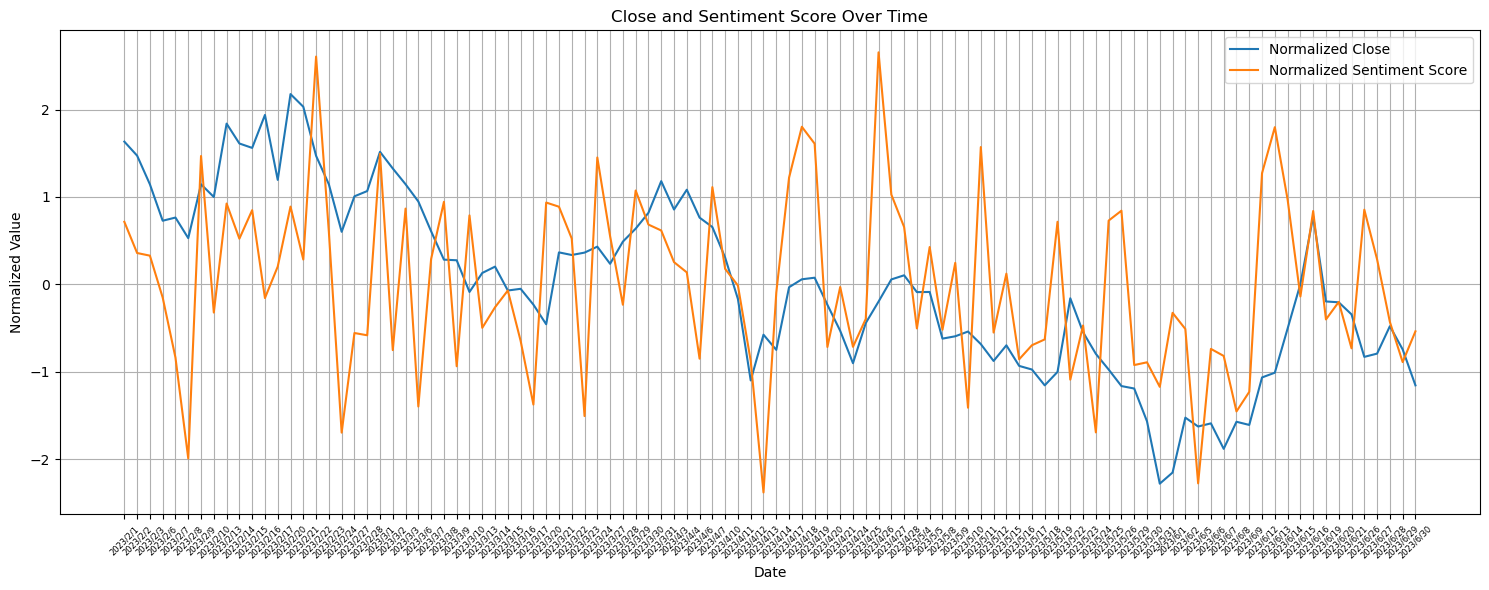

Correlation between sentiment score and stock close: 0.3382649929870049


In [23]:
# Create a new DataFrame containing the columns that you want to standardize
data_to_normalize = hd1[['close', 'Sentiment_score']]

# The Z-score method was used for standardization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_to_normalize)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=['normalized_close', 'normalized_sentiment'])

# Merge the normalized data into the original DataFrame
hd1_normalized = pd.concat([hd1, normalized_df], axis=1)

# Create a line chart
plt.figure(figsize=(15, 6))
plt.plot(hd1_normalized['date'], hd1_normalized['normalized_close'], label='Normalized Close')
plt.plot(hd1_normalized['date'], hd1_normalized['normalized_sentiment'], label='Normalized Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Close and Sentiment Score Over Time')
# Adjust the X-axis coordinate label
plt.xticks(rotation=45, fontsize=6)  # Adjust font size and Angle
#plt.gca().xaxis.set_major_locator(plt.MaxNLocator(110))  # Set the maximum number of ticks to 10

plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('The correlation between sentiment score and stock close.jpg',dpi=1080)
plt.show()

# Calculate the correlation between the emotion score and the rise and fall situation
correlation = hd1_normalized['normalized_sentiment'].corr(hd1_normalized['normalized_close'])

# Print dependency
print("Correlation between sentiment score and stock close:", correlation)


In [24]:
data_to_analyze = hd1_normalized[['normalized_close', 'normalized_sentiment']]

# Add columns of constant terms to prepare the data for the regression model
data_to_analyze = sm.add_constant(data_to_analyze)

# Create a linear regression model
model = sm.OLS(data_to_analyze['normalized_close'], data_to_analyze[['const', 'normalized_sentiment']])

# Fitting model
results = model.fit()

# Print the regression analysis results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       normalized_close   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     12.92
Date:                Mon, 21 Aug 2023   Prob (F-statistic):           0.000506
Time:                        14:17:00   Log-Likelihood:                -138.53
No. Observations:                 102   AIC:                             281.1
Df Residuals:                     100   BIC:                             286.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.341e-15 

<Axes: >

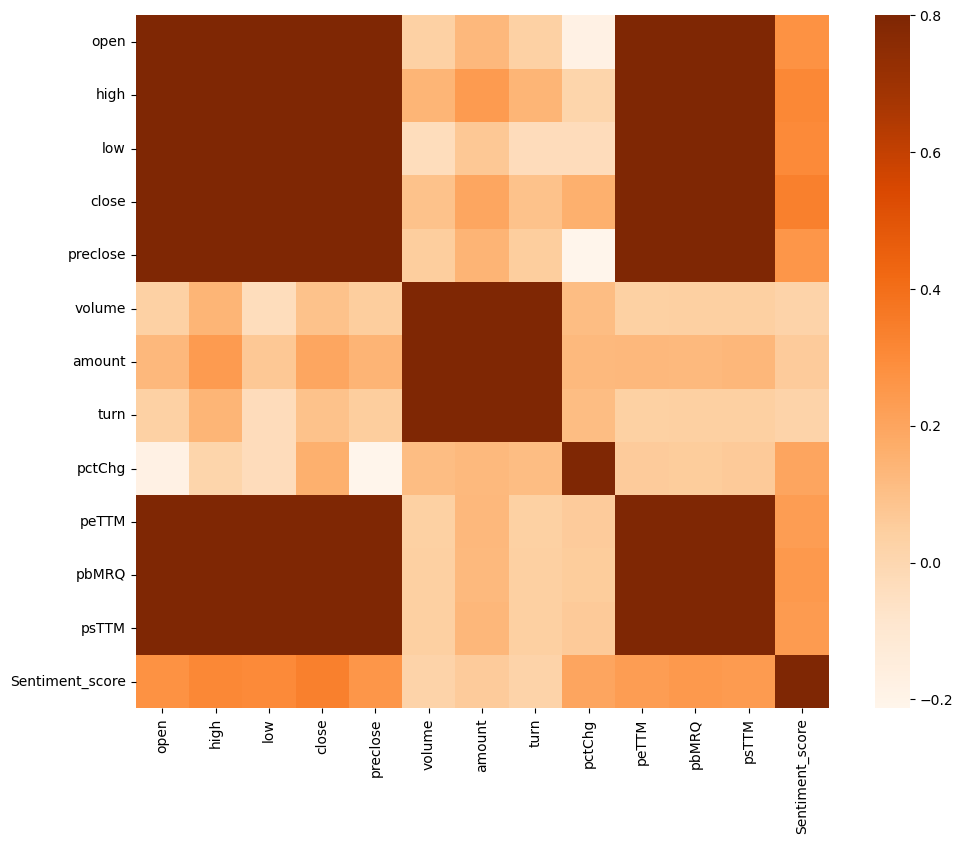

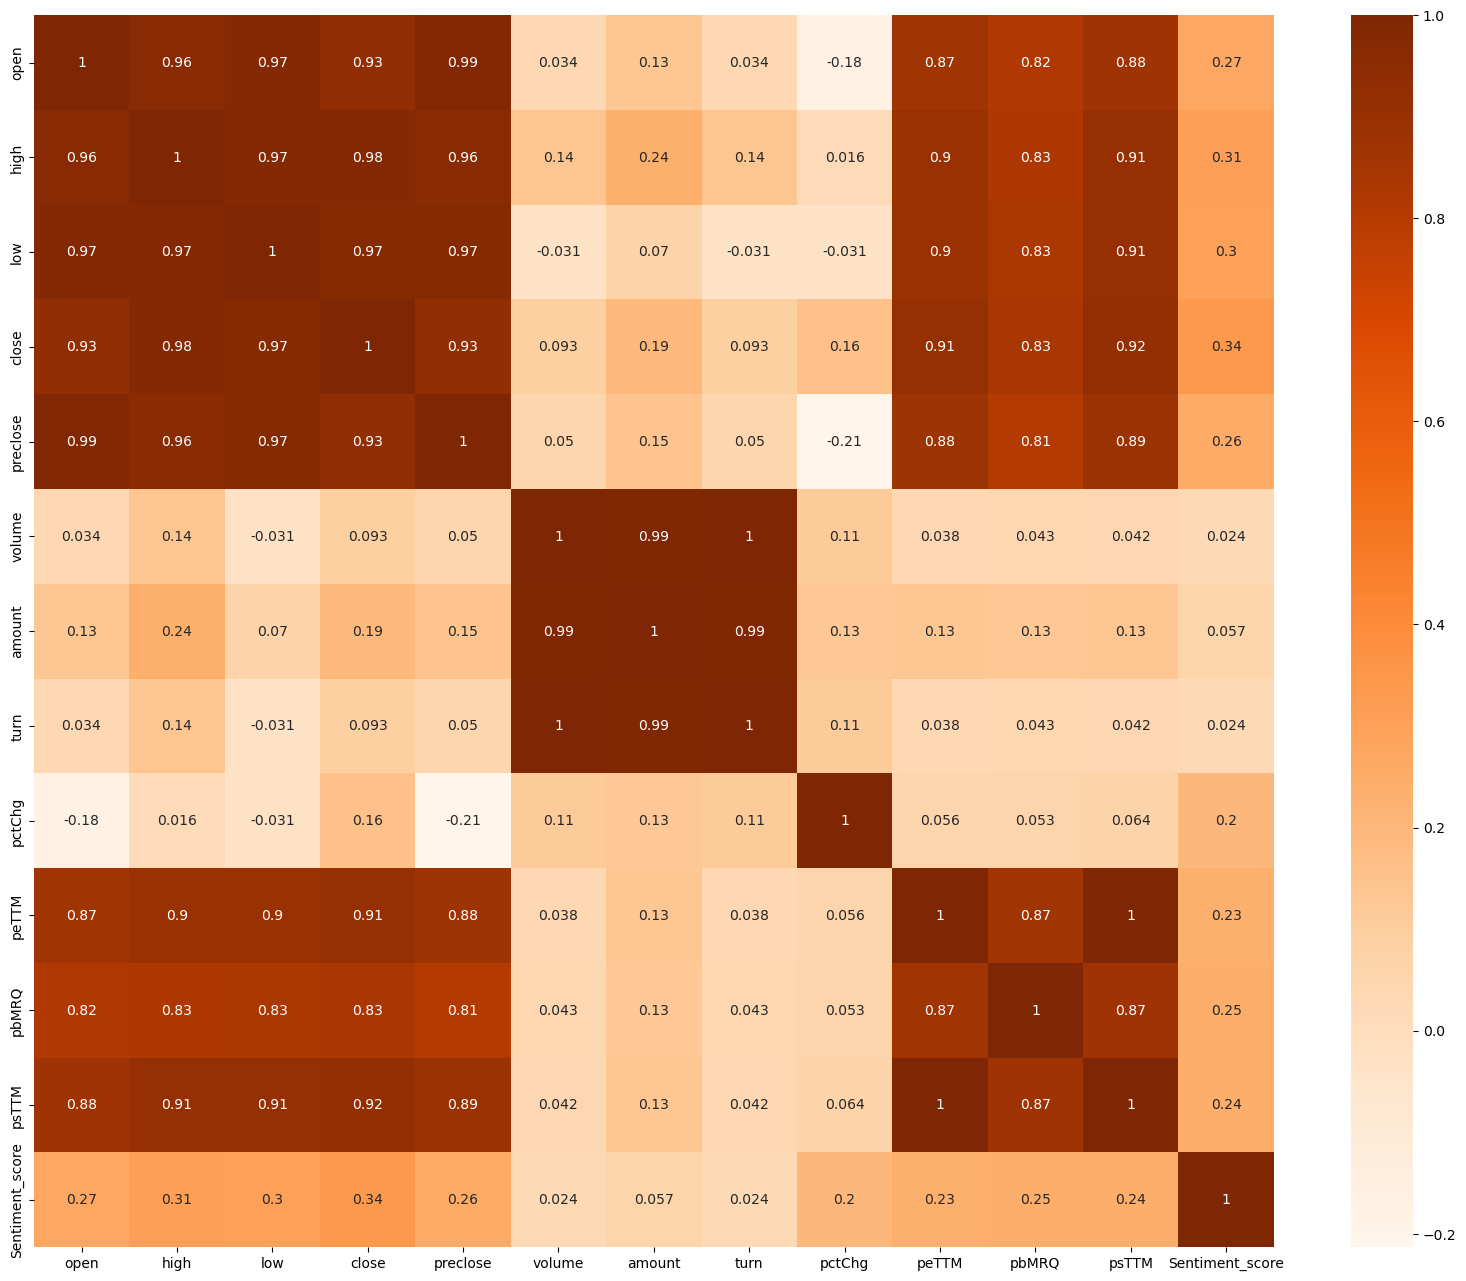

In [25]:
# drop date & code
hd1_corr = hd1.copy()
hd1_corr = hd1_corr.drop(['date', 'code', 'adjustflag', 'tradestatus'], axis=1)


# The correlation coefficients between each feature
corr = hd1_corr.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr,cmap="Oranges", vmax=.8, square=True)

plt.figure(figsize=(20, 16))
sns.heatmap(corr, cmap="Oranges", annot=True)
#plt.savefig('The correlation coefficients between each feature.jpg',dpi=1080)

In [26]:
hd1

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,Sentiment_score
0,2023/2/1,sh.600519,1854.98,1859.00,1811.40,1844.97,1845.76,3397389,6244678925,3,0.2705,1,-0.0428,38.890754,11.212138,18.966482,34.420921
1,2023/2/2,sh.600519,1848.38,1859.00,1826.00,1836.11,1844.97,2975886,5465509510,3,0.2369,1,-0.4802,38.703991,11.158294,18.875400,30.352075
2,2023/2/3,sh.600519,1820.00,1826.00,1795.68,1818.00,1836.11,3494490,6324635031,3,0.2782,1,-0.9863,38.322244,11.048237,18.689227,30.006892
3,2023/2/6,sh.600519,1780.00,1795.00,1760.00,1795.00,1818.00,4266095,7595739044,3,0.3396,1,-1.2651,37.837419,10.908463,18.452785,24.545402
4,2023/2/7,sh.600519,1808.08,1808.80,1787.73,1797.00,1795.00,2432171,4373671735,3,0.1936,1,0.1114,37.879578,10.920617,18.473345,16.715851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2023/6/26,sh.600519,1720.11,1730.00,1695.00,1709.00,1735.83,2399268,4098619510,3,0.1910,1,-1.5457,32.397164,9.835461,16.051623,36.003982
98,2023/6/27,sh.600519,1709.99,1719.70,1700.09,1711.05,1709.00,1517446,2598138744,3,0.1208,1,0.1200,32.436025,9.847259,16.070878,29.519177
99,2023/6/28,sh.600519,1713.18,1734.00,1711.00,1728.38,1711.05,1857356,3199294221,3,0.1479,1,1.0128,32.764546,9.946995,16.233648,21.361920
100,2023/6/29,sh.600519,1731.00,1734.99,1713.01,1713.71,1728.38,1423116,2446524134,3,0.1133,1,-0.8488,32.486450,9.862567,16.095862,16.130090


# Model implementation <a class="anchor" id="3"></a>

## Construction of model training set and test set <a class="anchor" id="3.1"></a>


In [27]:
# Feature selection and processing
selected_features = ['open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'turn', 'pctChg', 'peTTM',
       'pbMRQ', 'psTTM']

X = hd1[selected_features]
y = (hd1['close'].shift(-1) > hd1['close']).astype(int)  # The rise and fall of the next day as the target variable

# The data is split into training sets and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression without sentiment data <a class="anchor" id="3.2"></a>

In [28]:
lr = LogisticRegression(
                        penalty = 'l2',
                        dual = False,
                        random_state=42,
                        solver='liblinear'
                    
                 
)

lr_param_grid = {
    'C':np.linspace(0.1,1,10),
    'max_iter':range(50,200,10),
}

gs = GridSearchCV(lr,lr_param_grid, scoring='accuracy', cv=5)


gs.fit(X_train_scaled, y_train)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)


{'C': 1.0, 'max_iter': 50}
0.5551470588235294



LogisticRegression_train, CA          : 62.96%
LogisticRegression_train, Precision   : 61.82%
LogisticRegression_train, Recall      : 62.96%
LogisticRegression_train, F1          : 60.33%
LogisticRegression_test,  CA          : 61.90%
LogisticRegression_test,  Precision   : 64.63%
LogisticRegression_test,  Recall      : 61.90%
LogisticRegression_test,  F1          : 60.85%

              precision    recall  f1-score   support

           0       0.57      0.80      0.67        10
           1       0.71      0.45      0.56        11

    accuracy                           0.62        21
   macro avg       0.64      0.63      0.61        21
weighted avg       0.65      0.62      0.61        21



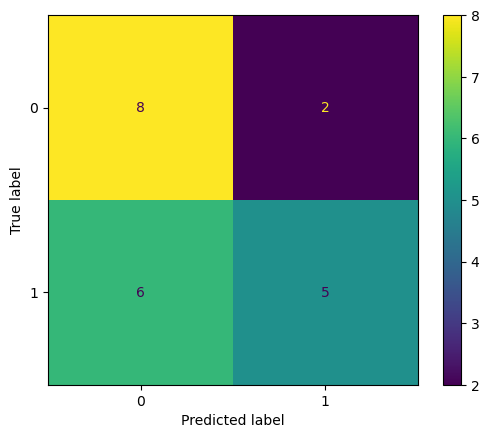

In [29]:
best_lr = LogisticRegression(
                        penalty = 'l2',
                        dual = False,
                        max_iter = best_params['max_iter'],
                        C = best_params['C'],  
                        random_state = 42,
                        solver='liblinear'
                        
                        
                    )

best_lr.fit(X_train_scaled, y_train)

Y_train_pre = best_lr.predict(X_train_scaled)
Y_test_pre = best_lr.predict(X_test_scaled)


scores = {}
scores['LogisticRegression_train, CA'] = accuracy_score(y_train,Y_train_pre)
scores['LogisticRegression_train, Precision'] = precision_score(y_train,Y_train_pre, average='weighted')
scores['LogisticRegression_train, Recall'] = recall_score(y_train,Y_train_pre, average='weighted')
scores['LogisticRegression_train, F1'] = f1_score(y_train,Y_train_pre, average='weighted')
print()
scores['LogisticRegression_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['LogisticRegression_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['LogisticRegression_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['LogisticRegression_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:38}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()
CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_LogisticRegression_without_sentiment.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))


## Random Forest without sentiment data<a class="anchor" id="3.3"></a>

In [30]:
# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion':['entropy', 'gini']
}

# Define a random forest classifier
rf = RandomForestClassifier(random_state=42)
# Cross validation using grid search
gs = GridSearchCV(rf,rf_param_grid,scoring='accuracy', n_jobs = -1, cv=5)
gs.fit(X_train_scaled, y_train)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.5669117647058823


RandomForest_train, CA         : 97.53%
RandomForest_train, Precision  : 97.63%
RandomForest_train, Recall     : 97.53%
RandomForest_train, F1         : 97.52%
RandomForest_test,  CA         : 57.14%
RandomForest_test,  Precision  : 60.32%
RandomForest_test,  Recall     : 57.14%
RandomForest_test,  F1         : 55.13%

              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.67      0.36      0.47        11

    accuracy                           0.57        21
   macro avg       0.60      0.58      0.56        21
weighted avg       0.60      0.57      0.55        21



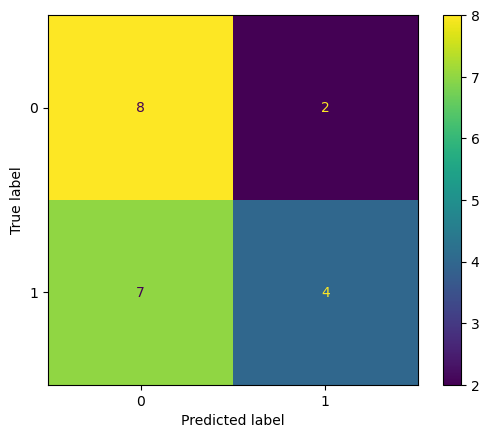

In [31]:
best_rf = RandomForestClassifier(
                        n_estimators = best_params['n_estimators'], 
                        max_depth = best_params['max_depth'], 
                        min_samples_split = best_params['min_samples_split'], 
                        min_samples_leaf = best_params['min_samples_leaf'], 
                        criterion = best_params['criterion'],
                        random_state=42)
best_rf.fit(X_train_scaled, y_train)

Y_train_pre = best_rf.predict(X_train_scaled)
Y_test_pre = best_rf.predict(X_test_scaled)


scores = {}
scores['RandomForest_train, CA'] = accuracy_score(y_train,Y_train_pre)
scores['RandomForest_train, Precision'] = precision_score(y_train,Y_train_pre, average='weighted')
scores['RandomForest_train, Recall'] = recall_score(y_train,Y_train_pre, average='weighted')
scores['RandomForest_train, F1'] = f1_score(y_train,Y_train_pre, average='weighted')

scores['RandomForest_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['RandomForest_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['RandomForest_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['RandomForest_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()
CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_RandomForest_without_sentiment.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))

## XGBoost without sentiment data <a class="anchor" id="3.4"></a>

In [32]:
model = xgb.XGBClassifier(random_state=42)


param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001]

}




gs = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy',n_jobs = -1, cv=5)
gs.fit(X_train_scaled, y_train)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)

{'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3}
0.5426470588235295


XGBClassifier_train, CA        : 74.07%
XGBClassifier_train, Precision : 74.22%
XGBClassifier_train, Recall    : 74.07%
XGBClassifier_train, F1        : 73.14%
XGBClassifier_test,  CA        : 57.14%
XGBClassifier_test,  Precision : 64.50%
XGBClassifier_test,  Recall    : 57.14%
XGBClassifier_test,  F1        : 52.70%

              precision    recall  f1-score   support

           0       0.53      0.90      0.67        10
           1       0.75      0.27      0.40        11

    accuracy                           0.57        21
   macro avg       0.64      0.59      0.53        21
weighted avg       0.64      0.57      0.53        21



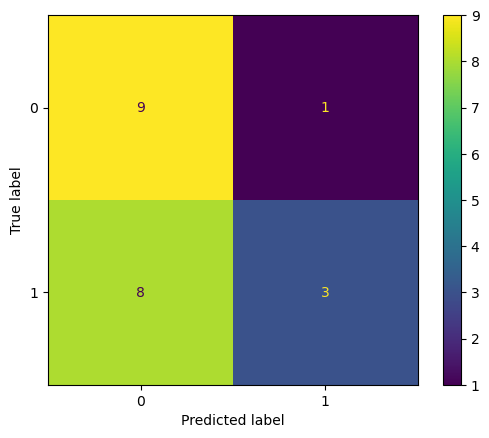

In [33]:

best_xg = xgb.XGBClassifier(
    max_depth=best_params['max_depth'], 
    learning_rate=best_params['learning_rate'], 
    min_child_weight=best_params['min_child_weight'], 
    random_state=42
)

best_xg.fit(X_train_scaled, y_train)

Y_train_pre = best_xg.predict(X_train_scaled)
Y_test_pre = best_xg.predict(X_test_scaled)


scores = {}
scores['XGBClassifier_train, CA'] = accuracy_score(y_train,Y_train_pre)
scores['XGBClassifier_train, Precision'] = precision_score(y_train,Y_train_pre, average='weighted')
scores['XGBClassifier_train, Recall'] = recall_score(y_train,Y_train_pre, average='weighted')
scores['XGBClassifier_train, F1'] = f1_score(y_train,Y_train_pre, average='weighted')

scores['XGBClassifier_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['XGBClassifier_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['XGBClassifier_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['XGBClassifier_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()

CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_XGBoost_without_sentiment.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))

## MLP without sentiment data <a class="anchor" id="3.5"></a>

MLPClassifier_train, CA        : 87.65%
MLPClassifier_train, Precision : 87.65%
MLPClassifier_train, Recall    : 87.65%
MLPClassifier_train, F1        : 87.65%
MLPClassifier_test,  CA        : 57.14%
MLPClassifier_test,  Precision : 58.38%
MLPClassifier_test,  Recall    : 57.14%
MLPClassifier_test,  F1        : 56.55%

              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.62      0.45      0.53        11

    accuracy                           0.57        21
   macro avg       0.58      0.58      0.57        21
weighted avg       0.58      0.57      0.57        21



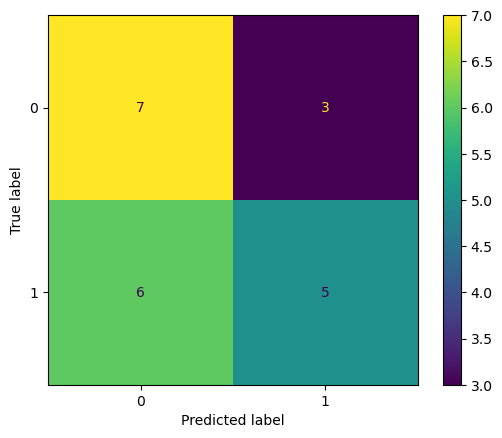

In [34]:
# Create a neural network model
nn_model = MLPClassifier(random_state=42)

# Model training
nn_model.fit(X_train_scaled, y_train)

# Model prediction
Y_train_pre = nn_model.predict(X_train_scaled)
Y_test_pre = nn_model.predict(X_test_scaled)

# Evaluation model
scores = {}


scores['MLPClassifier_train, CA'] = accuracy_score(y_train,Y_train_pre)
scores['MLPClassifier_train, Precision'] = precision_score(y_train,Y_train_pre, average='weighted')
scores['MLPClassifier_train, Recall'] = recall_score(y_train,Y_train_pre, average='weighted')
scores['MLPClassifier_train, F1'] = f1_score(y_train,Y_train_pre, average='weighted')

scores['MLPClassifier_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['MLPClassifier_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['MLPClassifier_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['MLPClassifier_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')



for k in scores:
    print('{0:31}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()

CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_MLP_without_sentiment.jpg', dpi=1080)
print(classification_report(y_test,Y_test_pre))

## Logistic regression model with sentiment data <a class="anchor" id="3.6"></a>

In [35]:
# Feature selection and processing
selected_features = ['open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'turn', 'pctChg', 'peTTM',
       'pbMRQ', 'psTTM', 'Sentiment_score']

X = hd1[selected_features]
y = (hd1['close'].shift(-1) > hd1['close']).astype(int)  # The rise and fall of the next day as the target variable

# The data is split into training sets and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
lr = LogisticRegression(
                        penalty = 'l2',
                        dual = False,
                        random_state=42,
                        solver='liblinear'
                    
                 
)

lr_param_grid = {
    'C':np.linspace(0.1,1,10),
    'max_iter':range(50,200,10),
}

gs = GridSearchCV(lr,lr_param_grid, scoring='accuracy', cv=5)


gs.fit(X_train_scaled, y_train)

best_params = gs.best_params_

print(best_params)
print(gs.best_score_)


{'C': 0.5, 'max_iter': 50}
0.5426470588235295


LogisticRegression_with_sentiment_train, CA          : 60.49%
LogisticRegression_with_sentiment_train, Precision   : 58.61%
LogisticRegression_with_sentiment_train, Recall      : 60.49%
LogisticRegression_with_sentiment_train, F1          : 56.99%
LogisticRegression_with_sentiment_test,  CA          : 71.43%
LogisticRegression_with_sentiment_test,  Precision   : 75.51%
LogisticRegression_with_sentiment_test,  Recall      : 71.43%
LogisticRegression_with_sentiment_test,  F1          : 70.63%

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.86      0.55      0.67        11

    accuracy                           0.71        21
   macro avg       0.75      0.72      0.71        21
weighted avg       0.76      0.71      0.71        21



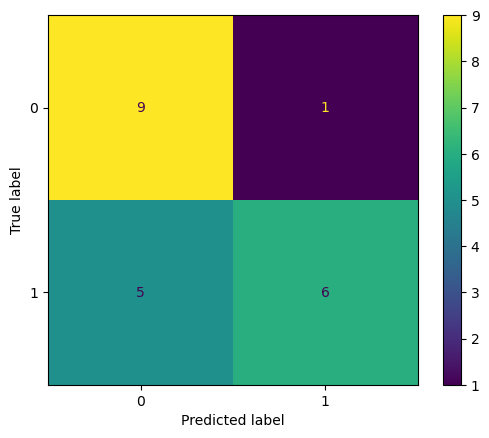

In [37]:
best_lr = LogisticRegression(
                        penalty = 'l2',
                        dual = False,
                        max_iter = best_params['max_iter'],
                        C = best_params['C'],  
                        random_state = 42,
                        solver='liblinear'
                        
                        
                    )

best_lr.fit(X_train_scaled, y_train)


Y_train_pre = best_lr.predict(X_train_scaled)
Y_test_pre = best_lr.predict(X_test_scaled)


scores = {}
scores['LogisticRegression_with_sentiment_train, CA'] = accuracy_score(y_train,Y_train_pre)
scores['LogisticRegression_with_sentiment_train, Precision'] = precision_score(y_train,Y_train_pre, average='weighted')
scores['LogisticRegression_with_sentiment_train, Recall'] = recall_score(y_train,Y_train_pre, average='weighted')
scores['LogisticRegression_with_sentiment_train, F1'] = f1_score(y_train,Y_train_pre, average='weighted')

scores['LogisticRegression_with_sentiment_test,  CA'] = accuracy_score(y_test,Y_test_pre)
scores['LogisticRegression_with_sentiment_test,  Precision'] = precision_score(y_test, Y_test_pre, average='weighted')
scores['LogisticRegression_with_sentiment_test,  Recall'] = recall_score(y_test, Y_test_pre, average='weighted')
scores['LogisticRegression_with_sentiment_test,  F1'] = f1_score(y_test, Y_test_pre, average='weighted')

for k in scores:
    print('{0:53}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()
CM=confusion_matrix(y_test,Y_test_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_LogisticRegression_with_sentiment.jpg',dpi=1080)
print(classification_report(y_test,Y_test_pre))


# Determination of the final model <a class="anchor" id="4"></a>

## Use all the data to train, save as a Sentiment-LogisticRegression model <a class="anchor" id="4.1"></a>

In [38]:
# Feature selection and processing
selected_features = ['open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'turn', 'pctChg', 'peTTM',
       'pbMRQ', 'psTTM', 'Sentiment_score']

X = hd1[selected_features]
y = (hd1['close'].shift(-1) > hd1['close']).astype(int)  # The rise and fall of the next day as the target variable


# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [39]:
best_lr = LogisticRegression(
                        penalty = 'l2',
                        dual = False,
                        max_iter = 50,
                        C = 0.5,  
                        random_state = 42,
                        solver='liblinear'                    
                        
                    )

best_lr.fit(X_scaled, y)
joblib.dump(best_lr, 'Sentiment-LogisticRegression_model.pkl')

Y_pre = best_lr.predict(X_scaled)



# Validate the validity of the final model <a class="anchor" id="5"></a>

## New data processing <a class="anchor" id="5.1"></a>

In [40]:
hd_new = pd.read_csv("data/history_data_600519_month7.csv")
cd_new = pd.read_excel("data/Stock_commentary_600519_month7.xlsx")

In [41]:
hd_new['adjustflag'].unique()

array([3])

In [42]:
hd_new['tradestatus'].unique()

array([1])

In [43]:
rows_with_missing_values_new = hd_new[hd_new.isnull().any(axis=1)]
rows_with_missing_values_new


,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM
17,2023/7/26,sh.600519,1828.55,1835.99,1815.08,1828.55,1828.55,1961145,3580171484,3,0.1561,1,0.0000,NaN,NaN,NaN
18,2023/7/27,sh.600519,1836.00,1854.79,1828.70,1838.03,1828.55,2034043,3749635290,3,0.1619,1,0.5184,NaN,NaN,NaN


In [44]:
fill_values_new = [
    [34.66, 11.43, 17.17],
    [34.84, 11.49, 17.26]
]
#https://data.eastmoney.com/gzfx/detail/600519.html

# Fill the supplied values into the missing values and print the filled rows
for i, row_index in enumerate(rows_with_missing_values_new.index):
    hd_new.loc[row_index, ['peTTM', 'pbMRQ', 'psTTM']] = fill_values_new[i]
    print(f"Filled values in row {row_index}: {fill_values_new[i]}")


Filled values in row 17: [34.66, 11.43, 17.17]
Filled values in row 18: [34.84, 11.49, 17.26]


In [45]:
# Extract week, month, and day columns from the ' date' column
cd_new['week'] = cd_new[' date'].dt.dayofweek
cd_new['month'] = cd_new[' date'].dt.month
cd_new['day'] = cd_new[' date'].dt.day
cd_new = cd_new[~((cd_new[' date'].dt.month == 6) | (cd_new[' date'].dt.month == 8))]
# Define conditions for rows to be excluded
exclude_weekends = cd_new['week'].isin([5, 6])  # Saturday and Sunday

# Combine the conditions to get rows to exclude
rows_to_exclude = exclude_weekends

# Keep only the rows that are not in the excluded rows
cd_new = cd_new[~rows_to_exclude]

# Drop the added columns 'week', 'month', 'day'
cd_new.drop(columns=['week', 'month', 'day'], inplace=True)


In [46]:
cd_new['preprocess_text'] = cd_new[' Title'].apply(preprocess_text)
cd_new['remove_emoji'] = cd_new['preprocess_text'].apply(remove_emoji)
cd_new = cd_new[cd_new['remove_emoji'] != '']
cd_new = cd_new.dropna().drop_duplicates()
cd_new = preprocess_final(cd_new)

cd_new

,Read,Reply,Title,author,date,preprocess_text,remove_emoji,tokenized,filtered,lemmatized
105,3345,18,"Regarding the big consumption, the analysis o...",Shareholder Q0F8CK8779,2023-07-31 11:36:00,regarding the big consumption the analysis of...,regarding the big consumption the analysis of...,"[regarding, the, big, consumption, the, analys...","[regarding, big, consumption, analysis, recent...","[regarding, big, consumption, analysis, recent..."
106,1613,4,The specific direction of foreign investment ...,Stock Road Xunlong,2023-07-31 11:27:00,the specific direction of foreign investment ...,the specific direction of foreign investment ...,"[the, specific, direction, of, foreign, invest...","[specific, direction, foreign, investment, liq...","[specific, direction, foreign, investment, liq..."
107,135,0,"Monthly review: ""Seven turning over"" is not a...",Yimoke,2023-07-31 11:20:00,monthly review seven turning over is not absent,monthly review seven turning over is not absent,"[monthly, review, seven, turning, over, is, no...","[monthly, review, seven, turning, absent]","[monthly, review, seven, turning, absent]"
108,164,0,This wave of consumer sector soared Moutai di...,Jimin l68927291P,2023-07-31 10:48:00,this wave of consumer sector soared moutai di...,this wave of consumer sector soared moutai di...,"[this, wave, of, consumer, sector, soared, mou...","[wave, consumer, sector, soared, moutai, direc...","[wave, consumer, sector, soared, moutai, direc..."
109,47,0,This wave of 3000 promotes consumption,Jimin l68927291P,2023-07-31 10:48:00,this wave of promotes consumption,this wave of promotes consumption,"[this, wave, of, promotes, consumption]","[wave, promotes, consumption]","[wave, promotes, consumption]"
...,...,...,...,...,...,...,...,...,...,...
4531,69,0,The dealer is happy and busy to ship goods.,Laofan stockholders 5199,2023-07-03 02:36:00,the dealer is happy and busy to ship goods,the dealer is happy and busy to ship goods,"[the, dealer, is, happy, and, busy, to, ship, ...","[dealer, happy, busy, ship, goods]","[dealer, happy, busy, ship, good]"
4532,43,0,"The awesomeness has passed, and the way back ...",Laofan stockholders 5199,2023-07-03 02:35:00,the awesomeness has passed and the way back i...,the awesomeness has passed and the way back i...,"[the, awesomeness, has, passed, and, the, way,...","[awesomeness, passed, way, back, necessary]","[awesomeness, passed, way, back, necessary]"
4533,57,0,Also rose a duck.,Laofan stockholders 5199,2023-07-03 02:33:00,also rose a duck,also rose a duck,"[also, rose, a, duck]","[also, rose, duck]","[also, rose, duck]"
4534,53,0,It's okay to show the century-old value.,Laofan stockholders 5199,2023-07-03 02:33:00,its okay to show the centuryold value,its okay to show the centuryold value,"[its, okay, to, show, the, centuryold, value]","[okay, show, centuryold, value]","[okay, show, centuryold, value]"


In [47]:
cd_new = cd_new.iloc[:,[0,1,9,2,3,4]]
cd_new = cd_new.rename(columns={'lemmatized': 'text'})

cd_new


,Read,Reply,text,Title,author,date
105,3345,18,"[regarding, big, consumption, analysis, recent...","Regarding the big consumption, the analysis o...",Shareholder Q0F8CK8779,2023-07-31 11:36:00
106,1613,4,"[specific, direction, foreign, investment, liq...",The specific direction of foreign investment ...,Stock Road Xunlong,2023-07-31 11:27:00
107,135,0,"[monthly, review, seven, turning, absent]","Monthly review: ""Seven turning over"" is not a...",Yimoke,2023-07-31 11:20:00
108,164,0,"[wave, consumer, sector, soared, moutai, direc...",This wave of consumer sector soared Moutai di...,Jimin l68927291P,2023-07-31 10:48:00
109,47,0,"[wave, promotes, consumption]",This wave of 3000 promotes consumption,Jimin l68927291P,2023-07-31 10:48:00
...,...,...,...,...,...,...
4531,69,0,"[dealer, happy, busy, ship, good]",The dealer is happy and busy to ship goods.,Laofan stockholders 5199,2023-07-03 02:36:00
4532,43,0,"[awesomeness, passed, way, back, necessary]","The awesomeness has passed, and the way back ...",Laofan stockholders 5199,2023-07-03 02:35:00
4533,57,0,"[also, rose, duck]",Also rose a duck.,Laofan stockholders 5199,2023-07-03 02:33:00
4534,53,0,"[okay, show, centuryold, value]",It's okay to show the century-old value.,Laofan stockholders 5199,2023-07-03 02:33:00


In [48]:
# Run a sentiment analysis on each tweet
sentiment_scores_new = []
for text in cd_new['text']:
    sentiment_score = sentiment_analysis(text)
    sentiment_scores_new.append(sentiment_score)

# Add sentiment analysis results to the raw data table
cd_new['Sentiment_polarity'] = [score[0] for score in sentiment_scores_new]

# Print the sentiment analysis results
cd_new = cd_new[['Read', ' Reply', 'text', ' date', 'Sentiment_polarity']]
cd_new


,Read,Reply,text,date,Sentiment_polarity
105,3345,18,"[regarding, big, consumption, analysis, recent...",2023-07-31 11:36:00,0.026250
106,1613,4,"[specific, direction, foreign, investment, liq...",2023-07-31 11:27:00,0.003788
107,135,0,"[monthly, review, seven, turning, absent]",2023-07-31 11:20:00,0.000000
108,164,0,"[wave, consumer, sector, soared, moutai, direc...",2023-07-31 10:48:00,0.100000
109,47,0,"[wave, promotes, consumption]",2023-07-31 10:48:00,0.000000
...,...,...,...,...,...
4531,69,0,"[dealer, happy, busy, ship, good]",2023-07-03 02:36:00,0.533333
4532,43,0,"[awesomeness, passed, way, back, necessary]",2023-07-03 02:35:00,0.000000
4533,57,0,"[also, rose, duck]",2023-07-03 02:33:00,0.600000
4534,53,0,"[okay, show, centuryold, value]",2023-07-03 02:33:00,0.500000


In [49]:

cd_new['Days_score'] = (cd_new['Read'] + cd_new[' Reply']) * cd_new['Sentiment_polarity']


cd_new


,Read,Reply,text,date,Sentiment_polarity,Days_score
105,3345,18,"[regarding, big, consumption, analysis, recent...",2023-07-31 11:36:00,0.026250,88.27875
106,1613,4,"[specific, direction, foreign, investment, liq...",2023-07-31 11:27:00,0.003788,6.12500
107,135,0,"[monthly, review, seven, turning, absent]",2023-07-31 11:20:00,0.000000,0.00000
108,164,0,"[wave, consumer, sector, soared, moutai, direc...",2023-07-31 10:48:00,0.100000,16.40000
109,47,0,"[wave, promotes, consumption]",2023-07-31 10:48:00,0.000000,0.00000
...,...,...,...,...,...,...
4531,69,0,"[dealer, happy, busy, ship, good]",2023-07-03 02:36:00,0.533333,36.80000
4532,43,0,"[awesomeness, passed, way, back, necessary]",2023-07-03 02:35:00,0.000000,0.00000
4533,57,0,"[also, rose, duck]",2023-07-03 02:33:00,0.600000,34.20000
4534,53,0,"[okay, show, centuryold, value]",2023-07-03 02:33:00,0.500000,26.50000


In [50]:
# Calculate the mean and standard deviation
mean = cd_new['Days_score'].mean()
std = cd_new['Days_score'].std()

# Define a threshold range to judge extreme values
lower_threshold = mean - std
upper_threshold = mean + std

# Delete the row where the extreme value resides
cd_new = cd_new[(cd_new['Days_score'] >= lower_threshold) & (cd_new['Days_score'] <= upper_threshold)]

# Print the filtered statistical description
print(cd_new['Days_score'].describe())


count    3732.000000
mean       17.368213
std        97.999691
min      -714.600000
25%         0.000000
50%         0.000000
75%        15.350000
max       841.600000
Name: Days_score, dtype: float64


In [51]:
cd_new['Date'] = cd_new[' date'].dt.date

# Group by date to calculate the number of comments per day and the total score
grouped = cd_new.groupby('Date').agg({'Days_score': 'sum', 'text': 'count'})

# Calculate the sentiment_score for each day
grouped['Sentiment_score'] = grouped['Days_score'] / grouped['text']

# Retain the date and sentiment_score columns
cd_new = grouped.reset_index()
cd_new = cd_new[['Date','Sentiment_score']]
hd_new['Sentiment_score'] = cd_new['Sentiment_score']

hd_new

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,Sentiment_score
0,2023/7/3,sh.600519,1699.00,1725.28,1692.00,1724.10,1691.00,1913909,3286737792,3,0.1524,1,1.9574,32.683411,9.922363,16.193449,12.835475
1,2023/7/4,sh.600519,1724.20,1734.44,1718.08,1730.60,1724.10,1247238,2155553635,3,0.0993,1,0.3770,32.806630,9.959771,16.254499,0.743019
2,2023/7/5,sh.600519,1730.00,1731.97,1700.00,1715.38,1730.60,1474539,2523960725,3,0.1174,1,-0.8795,32.518108,9.872178,16.111547,12.189354
3,2023/7/6,sh.600519,1709.16,1733.00,1700.00,1702.98,1715.38,1514062,2589459002,3,0.1205,1,-0.7229,32.283044,9.800815,15.995081,10.378917
4,2023/7/7,sh.600519,1701.00,1708.99,1690.00,1690.03,1702.98,1516742,2571458553,3,0.1207,1,-0.7604,32.037553,9.726287,15.873449,13.026683
5,2023/7/10,sh.600519,1705.00,1714.96,1700.00,1700.90,1690.03,1347741,2298241728,3,0.1073,1,0.6432,32.243614,9.788845,15.975545,22.728177
6,2023/7/11,sh.600519,1710.00,1715.17,1702.10,1710.00,1700.90,1258270,2151079270,3,0.1002,1,0.5350,32.416120,9.841216,16.061016,25.594044
7,2023/7/12,sh.600519,1713.04,1723.00,1711.33,1713.80,1710.00,1328467,2280785351,3,0.1058,1,0.2222,32.488156,9.863085,16.096707,15.388847
8,2023/7/13,sh.600519,1721.99,1745.41,1719.01,1738.40,1713.80,2580654,4479772500,3,0.2054,1,1.4354,32.954493,10.004661,16.327760,20.858085
9,2023/7/14,sh.600519,1756.00,1758.50,1741.20,1753.00,1738.40,1855030,3245530255,3,0.1477,1,0.8399,33.231263,10.088685,16.464889,26.918513


## Display of performance results using new data <a class="anchor" id="5.2"></a>

In [52]:
# Feature selection and processing
selected_features = ['open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'turn', 'pctChg', 'peTTM',
       'pbMRQ', 'psTTM', 'Sentiment_score']

X = hd_new[selected_features]
y = (hd_new['close'].shift(-1) > hd_new['close']).astype(int)  # The rise and fall of the next day as the target variable


# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Setiment-LogisticRegression, CA       : 66.67%
Setiment-LogisticRegression, Precision: 73.47%
Setiment-LogisticRegression, Recall   : 66.67%
Setiment-LogisticRegression, F1       : 65.90%

              precision    recall  f1-score   support

           0       0.57      0.89      0.70         9
           1       0.86      0.50      0.63        12

    accuracy                           0.67        21
   macro avg       0.71      0.69      0.66        21
weighted avg       0.73      0.67      0.66        21



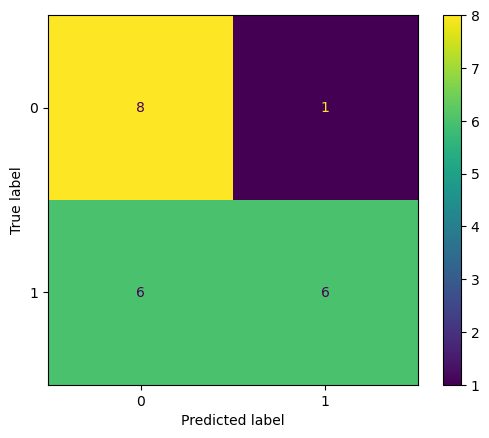

In [53]:
LR_model = joblib.load('Sentiment-LogisticRegression_model.pkl')
Y_pre = LR_model.predict(X_scaled)


scores = {}
scores['Sentiment-LogisticRegression, CA'] = accuracy_score(y, Y_pre)
scores['Sentiment-LogisticRegression, Precision'] = precision_score(y, Y_pre, average='weighted')
scores['Sentiment-LogisticRegression, Recall'] = recall_score(y, Y_pre, average='weighted')
scores['Sentiment-LogisticRegression, F1'] = f1_score(y, Y_pre, average='weighted')


for k in scores:
    print('{0:38}: {1:5.2f}%'.format(k, np.mean(scores[k])*100) )
    
print()
CM=confusion_matrix(y, Y_pre)
ConfusionMatrixDisplay(CM).plot()
#plt.savefig('confusion_matrix_Sentiment-LogisticRegression.jpg',dpi=1080)
print(classification_report(y, Y_pre))
